# Functional urban area (FUAs) projection

Project central european functional urban areas onto 2 PCA components, based on the distribution of urban fabric types within each FUA.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

v = 'v10'

target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

In [2]:
fuas = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)

In [3]:
# fuas.explore()

Assign a FUA identifier for every building.

In [4]:
%%time

results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 48s, sys: 7.82 s, total: 1min 56s
Wall time: 1min 47s


In [5]:
all_fua_buildings.head()

,currentUse,buildingNature,heightAboveGround,iid,geometry,label,morph,final,final_without_noise,city,...,beginLifespanVersion,conditionOfConstruction,localId,namespace,versionId,referenceGeometry,horizontalGeometryEstimatedAccuracy,x,y,id
0,Nach Quellenlage nicht zu spezifizieren,Gebäude,NaN,28283100,"POLYGON ((4084658.933 3111002.372, 4084660.633...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Schuppen,Gebäude,NaN,37719199,"POLYGON ((4084690.442 3111047.559, 4084691.964...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wohnhaus,Gebäude,NaN,37719200,"POLYGON ((4084677.785 3111047.165, 4084682.222...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nach Quellenlage nicht zu spezifizieren,Gebäude,NaN,28283081,"POLYGON ((4084670.573 3111046.746, 4084674.818...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Carport,Sonstiges Bauwerk oder sonstige Einrichtung,NaN,32590234,"POLYGON ((4084688.661 3111052.389, 4084690.753...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# all_fua_buildings.iloc[:1000].explore()

Assign cluster identifiers at a specified level for every building,  aggregate the building data to functional areas, calculate the distribution of urban fabric clusters and compute the principle components.

In [7]:
def generate_pca_plot_at_level(building_data, level, by_area=False):
    """Generate a PCA dataframe from a building data frame"""
    
    # Assign cluster identifiers at a specified level for every building
    if by_area:
        subset = all_fua_buildings[['country', 'city', 'final_without_noise', 'geometry']]
        subset = subset[subset.city != 'Lubin']
    else:
        subset = building_data[['country', 'city', 'final_without_noise']]
    
    if level < 7:
        subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())

    # aggregate the building data to functional areas
    if by_area:
        res = subset.groupby(['country', 'city', 'final_without_noise'])['geometry'].apply(lambda x: x.area.sum())
        res = res.unstack(-1).fillna(0)
    else:
        res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
        res = res.unstack(-1).fillna(0).astype(int)
    
    # normalise based on counts
    # note: normalisation can be based on building area too
    X = res.values / res.sum(axis=1).values[:, np.newaxis]

    # compute the PCs and return the results
    pca = PCA(n_components=3)
    components = pca.fit_transform(X)
    print(pca.explained_variance_, pca.explained_variance_ratio_)
    
    df = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3'])
    df.loc[:, 'city'] = res.index.get_level_values(1).values
    df.loc[:, 'country'] = res.index.get_level_values(0).values
    return df

[0.01078344 0.00207174 0.00159899] [0.40060624 0.07696545 0.05940285]
[0.01685554 0.00408767 0.00284701] [0.42768216 0.10371793 0.07223824]
[0.03089917 0.0057553  0.00416522] [0.54089612 0.10074768 0.07291306]
[0.03283528 0.00722979 0.0062452 ] [0.55343247 0.12185682 0.10526175]
[0.06720689 0.00695715 0.00579046] [0.7892084  0.08169757 0.06799715]
[0.11230162 0.00357662 0.0004964 ] [0.96500079 0.03073364 0.00426557]


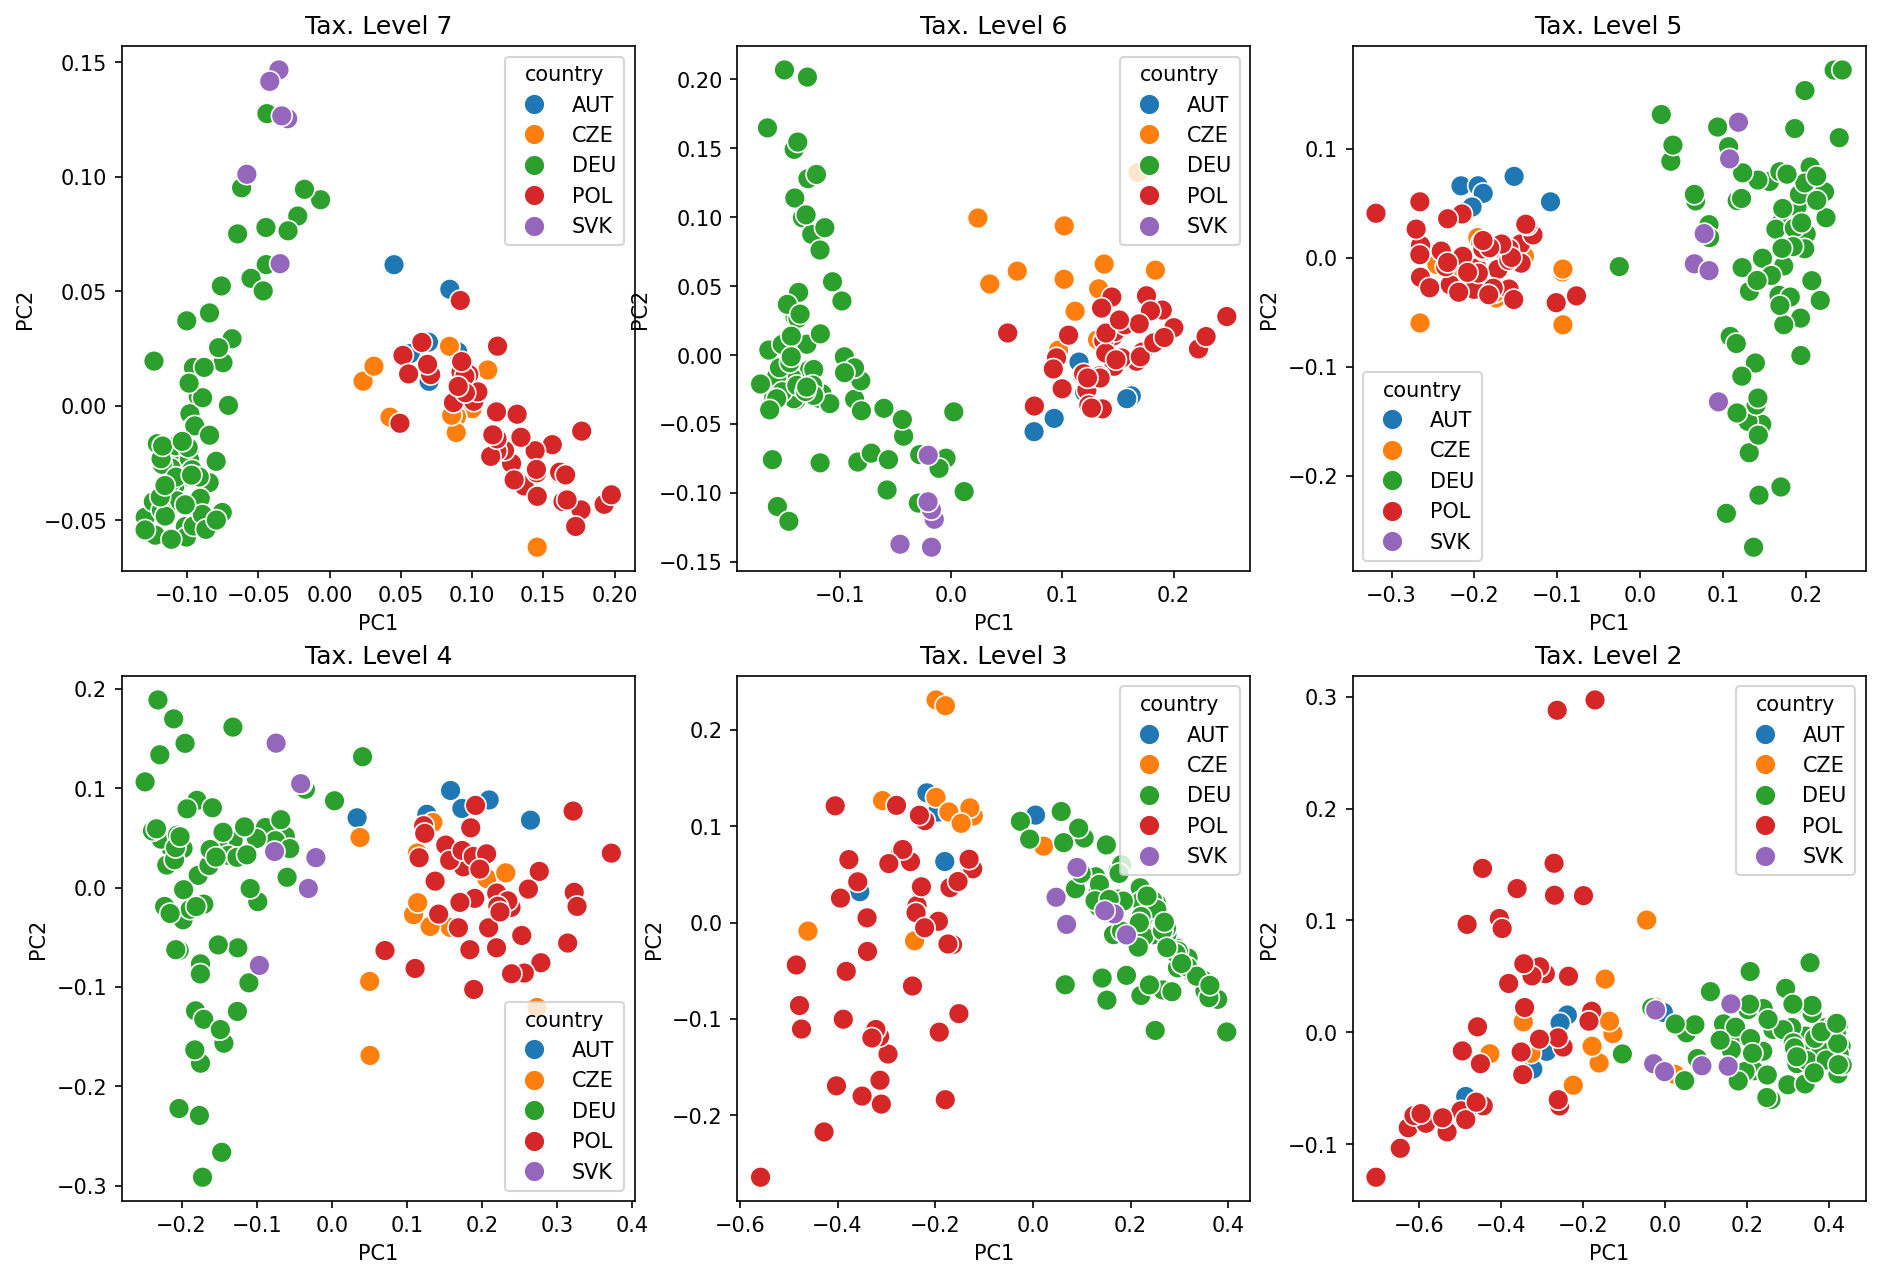

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

for level, ax in zip(range(7, 1, -1), axes.flatten()):
    df = generate_pca_plot_at_level(all_fua_buildings, level, by_area=False)
    sns.scatterplot(x="PC1", y="PC2", hue='country', data=df, s=100, ax=ax)
    ax.set_title(f'Tax. Level {level}')

Assign a geometry, to try out different coloring schemes based on political boundaries.

In [9]:

level=7
df = generate_pca_plot_at_level(all_fua_buildings, level, by_area=False)
# assign a geometry
gdf_fuas = gpd.GeoDataFrame(df, geometry=fuas.set_index('eFUA_name').loc[df['city'].values, 'geometry'].values)

[0.01078344 0.00207174 0.00159899] [0.40060624 0.07696545 0.05940285]


In [10]:
# read boundaries
layer_names = gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name.values.tolist()

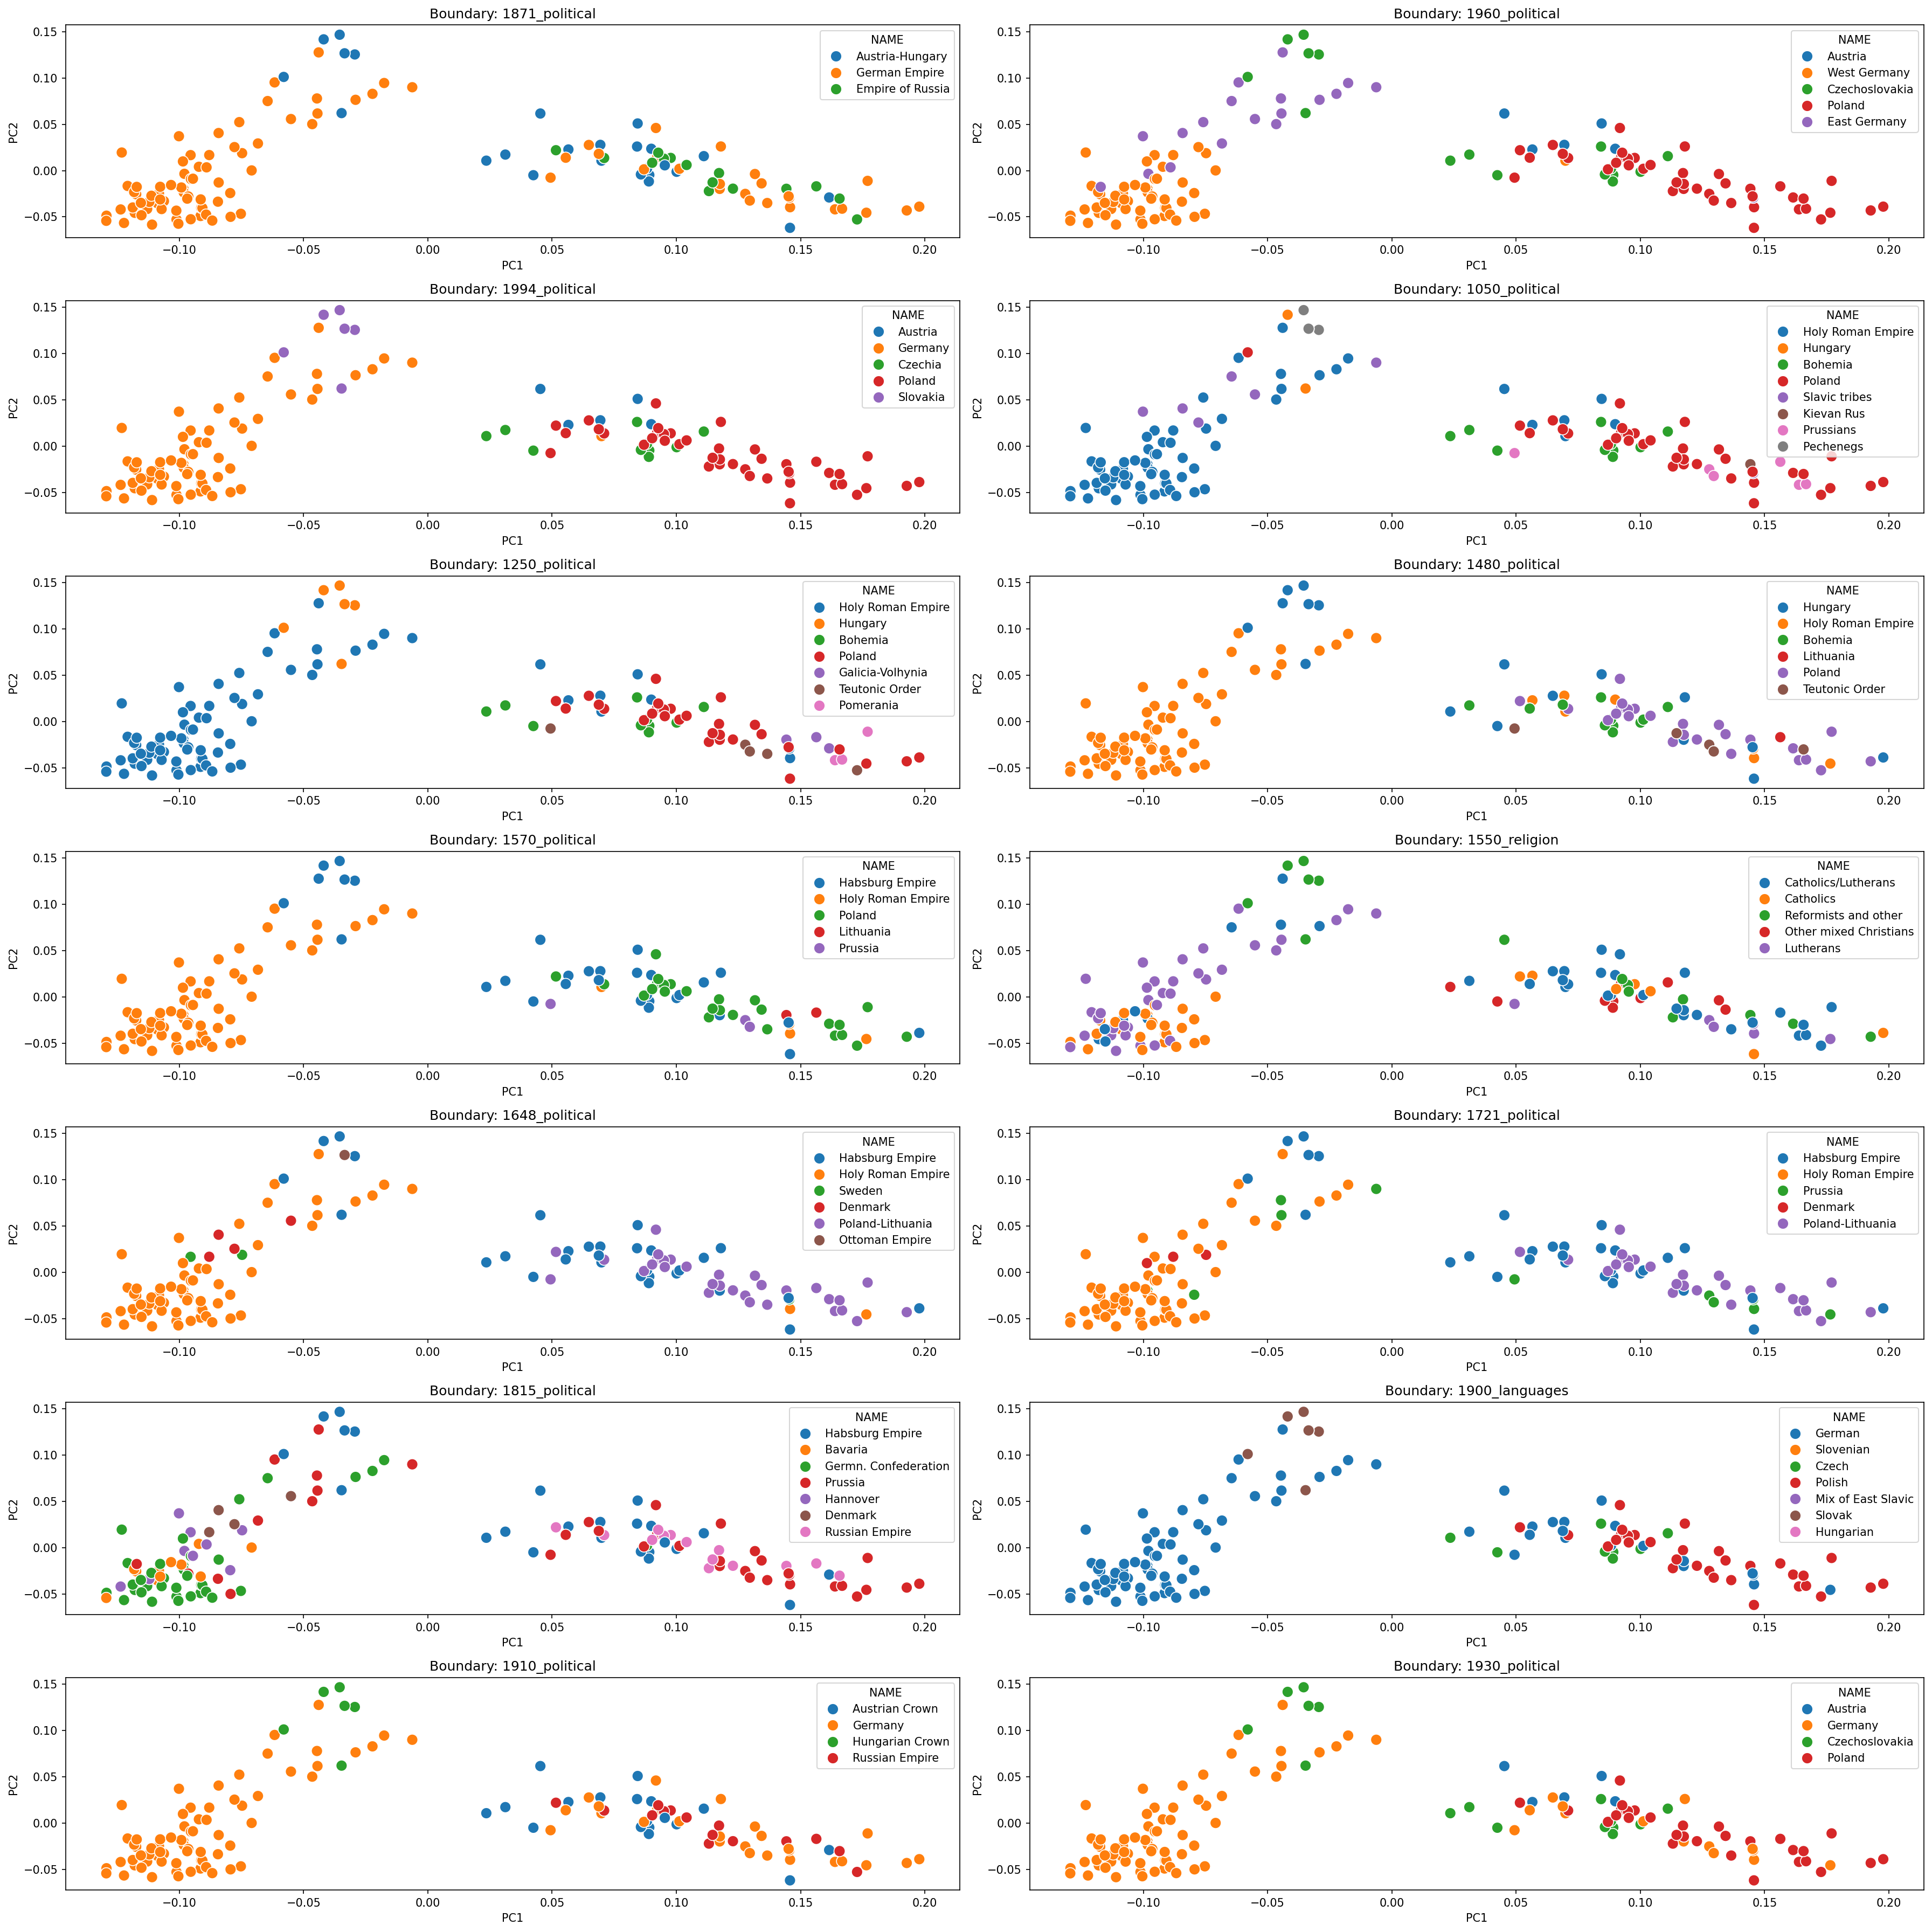

In [33]:
fig, axes = plt.subplots(7, 2, figsize=(24, 24), dpi=150)

for layer, ax in zip(layer_names, axes.flatten()):

    boundaries = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg', layer=layer)
    new_df = gdf_fuas.sjoin(boundaries)
    sns.scatterplot(x="PC1", y="PC2", hue='NAME', data=new_df, s=100, ax=ax)
    ax.set_title(f'Boundary: {layer}')

fig.tight_layout()

In [34]:
import jscatter
scatter = jscatter.Scatter(data=new_df, x='PC1', y='PC2', color_by='NAME', tooltip=True, tooltip_properties=["city", "NAME"], size=10)
scatter.background('#1E1E20')

scatter.show()

Direct compariosns between cities

In [35]:
# Assign cluster identifiers at a specified level for every building 
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
if level < 7:
    subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())

# aggregate the building data to functional areas
res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

# aggregate the building data to functional areas
res_area = all_fua_buildings[['country', 'city', 'final_without_noise', 'geometry']].groupby(['country', 'city', 'final_without_noise'])['geometry'].apply(lambda x: x.area.sum())
res_area = res_area.unstack(-1).fillna(0).reset_index(0, drop=True)

# normalise based on counts
# note: normalisation can be based on building area too
# X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [36]:
res = all_fua_buildings[['country', 'city', 'final_without_noise', 'geometry']].groupby(['country', 'city', 'final_without_noise'])['geometry'].apply(lambda x: x.area.sum())
res = res.unstack(-1).fillna(0)

In [37]:
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [38]:
X

array([[0.01664659, 0.01424746, 0.04524566, ..., 0.        , 0.        ,
        0.        ],
       [0.04694735, 0.00937668, 0.08197364, ..., 0.00654247, 0.00064515,
        0.00337311],
       [0.0496665 , 0.01659346, 0.06508995, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04825978, 0.10183168, 0.01730144, ..., 0.00201204, 0.00087408,
        0.        ],
       [0.04534629, 0.02013443, 0.02552308, ..., 0.00742939, 0.00630462,
        0.00408423],
       [0.0329425 , 0.04559159, 0.01585073, ..., 0.01098209, 0.00246621,
        0.00216554]], shape=(136, 110))

In [39]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

In [40]:
pca.explained_variance_ratio_

array([0.31378499, 0.17034674, 0.05222855])

In [41]:
X = res_area.values / res_area.sum(axis=1).values[:, np.newaxis]

In [42]:
X = pd.DataFrame(X, index=res_area.index, columns=res_area.columns)
X.name = ''
X

final_without_noise,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,109,110
city,,,,,,,,,,,,,,,,,,,,,
Graz,0.016647,0.014247,0.045246,0.013430,0.012798,0.006543,0.000000,0.0,0.0,0.021623,...,0.003965,0.000325,0.001095,0.000194,0.004959,0.002622,0.011157,0.000000,0.000000,0.000000
Innsbruck,0.046947,0.009377,0.081974,0.023198,0.015752,0.007926,0.000000,0.0,0.0,0.000000,...,0.001530,0.000124,0.003742,0.000000,0.007794,0.012870,0.048187,0.006542,0.000645,0.003373
Klagenfurt,0.049666,0.016593,0.065090,0.048360,0.010373,0.004723,0.000000,0.0,0.0,0.000000,...,0.002230,0.000086,0.000000,0.000000,0.009590,0.007707,0.026486,0.000000,0.000000,0.000000
Linz,0.058485,0.024267,0.037587,0.027688,0.008190,0.013824,0.000000,0.0,0.0,0.028095,...,0.007557,0.000949,0.001666,0.000498,0.004307,0.006208,0.013932,0.001043,0.000000,0.000000
Salzburg,0.052144,0.026838,0.060470,0.037858,0.012708,0.001305,0.000000,0.0,0.0,0.018377,...,0.008404,0.000847,0.003268,0.000000,0.024768,0.007093,0.024227,0.000637,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bratislava,0.053188,0.066948,0.036233,0.024872,0.007285,0.026121,0.012016,0.0,0.0,0.044694,...,0.008717,0.002106,0.000742,0.000813,0.001328,0.010091,0.012449,0.001841,0.005961,0.004580
Košice,0.102520,0.045099,0.025830,0.015074,0.000303,0.009558,0.000000,0.0,0.0,0.012492,...,0.005830,0.002347,0.000514,0.002010,0.001145,0.008195,0.002135,0.000000,0.002060,0.000026
Prešov,0.048260,0.101832,0.017301,0.012834,0.007500,0.009731,0.000000,0.0,0.0,0.001543,...,0.000214,0.000000,0.000799,0.000593,0.000007,0.005979,0.010118,0.002012,0.000874,0.000000


In [43]:
from sklearn.neighbors import KDTree

In [44]:
tree = KDTree(X)
dists, nns = tree.query(X.values, k=10)

In [45]:
X.index[nns[-1:, 1:].flatten()]

Index(['Prešov', 'Chemnitz', 'Gera', 'Hamburg', 'Bratislava',
       'Banská Bystrica', 'Lüneburg', 'Siegen', 'Bayreuth'],
      dtype='object', name='city')

In [46]:
X.loc[['Žilina', 'Chemnitz', 'Jena']].style.background_gradient(axis=0, cmap="BuGn")

final_without_noise,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Žilina,0.032943,0.045592,0.015851,0.006754,0.009202,0.026273,0.000000,0.000000,0.000000,0.029134,0.000000,0.000124,0.000000,0.016479,0.027959,0.016109,0.039460,0.024776,0.015249,0.000000,0.000000,0.000000,0.000000,0.000729,0.002224,0.004053,0.002754,0.001221,0.000851,0.000000,0.001545,0.000000,0.005717,0.000003,0.002017,0.001129,0.000791,0.007273,0.001308,0.004714,0.003291,0.003793,0.003047,0.012723,0.000000,0.000000,0.003176,0.000682,0.001631,0.000263,0.004210,0.000000,0.016882,0.000215,0.006671,0.014494,0.008570,0.000363,0.050931,0.057893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001511,0.000308,0.002006,0.001182,0.010737,0.000000,0.000000,0.033301,0.009004,0.014827,0.005523,0.000000,0.000000,0.000000,0.019471,0.031427,0.023011,0.040687,0.013205,0.012360,0.011800,0.005568,0.001730,0.002155,0.000000,0.004303,0.041458,0.012433,0.009475,0.019429,0.082645,0.013816,0.013286,0.000000,0.003163,0.002968,0.000000,0.000000,0.000722,0.007419,0.002395,0.010982,0.002466,0.002166
Chemnitz,0.026599,0.050279,0.030773,0.027630,0.017937,0.018652,0.000000,0.000000,0.000000,0.013076,0.000000,0.001576,0.000265,0.021690,0.028371,0.024247,0.018975,0.010875,0.008377,0.000000,0.000000,0.000128,0.000000,0.000828,0.000006,0.003343,0.001671,0.004347,0.000640,0.000000,0.000000,0.000000,0.002985,0.000000,0.000784,0.002089,0.008929,0.007907,0.007420,0.008336,0.007190,0.007735,0.010221,0.020218,0.000000,0.000000,0.018787,0.012201,0.006315,0.000012,0.004584,0.001059,0.029424,0.000000,0.001481,0.026991,0.032475,0.000031,0.027952,0.078808,0.000000,0.001302,0.000000,0.000559,0.000000,0.000000,0.000000,0.000286,0.000000,0.000735,0.027051,0.007001,0.014149,0.026092,0.015953,0.001748,0.011222,0.000000,0.000000,0.000595,0.001113,0.004259,0.007316,0.017563,0.005784,0.000839,0.004728,0.014995,0.000109,0.006065,0.000000,0.008641,0.014347,0.007362,0.028841,0.030320,0.029524,0.010691,0.026994,0.000003,0.003235,0.000663,0.001992,0.000560,0.002439,0.011556,0.009935,0.007136,0.000832,0.001246
Jena,0.048408,0.030088,0.036340,0.010933,0.009814,0.040617,0.000000,0.000000,0.000000,0.009808,0.000000,0.000000,0.000000,0.018374,0.015530,0.022659,0.069248,0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.007646,0.000479,0.007471,0.010095,0.001853,0.000000,0.000000,0.000973,0.000000,0.000894,0.000000,0.000613,0.000600,0.000549,0.003375,0.001255,0.003085,0.000345,0.001545,0.001038,0.009675,0.000000,0.000000,0.000026,0.000550,0.001277,0.000552,0.002638,0.002535,0.030487,0.001237,0.012016,0.013057,0.017894,0.000000,0.004066,0.021481,0.000000,0.000000,0.000000,0.000171,0.000000,0.000000,0.000000,0.004020,0.001225,0.023101,0.010004,0.000000,0.000000,0.011453,0.001024,0.016033,0.002973,0.000000,0.000000,0.000399,0.028269,0.013143,0.013883,0.017604,0.022425,0.014673,0.065053,0.012820,0.000000,0.006041,0.000865,0.012193,0.030326,0.017255,0.008143,0.017000,0.033887,0.006149,0.030358,0.000381,0.001474,0.001075,0.003922,0.000617,0.005185,0.015253,0.005407,0.029742,0.035548,0.009732


Assign population to a PCA dataframe

In [47]:

level=7
df = generate_pca_plot_at_level(all_fua_buildings, level)
population = fuas.set_index('eFUA_name').loc[df['city'].values, 'FUA_p_2015'].values
df['population'] = population

[0.01078344 0.00207174 0.00159899] [0.40060624 0.07696545 0.05940285]


In [48]:
df[df['city'] == 'Lubin']

,PC1,PC2,PC3,city,country,population
108,0.117445,-0.019787,-0.00035,Lubin,POL,106914.194417


Assign pca distance to every FUA. The `pca distance sums` is the sum of distances in PCA space, between a FUA and its 5 closest geographical neighbours.
The value is higher, for those FUA that are further away from their 5 closest geographical neighbours.

In [49]:
from libpysal.graph import Graph
from scipy.spatial.distance import cdist

In [50]:
pca_df = df[['PC1', 'PC2', 'city']].set_index('city')

city_centroids = fuas.set_index('eFUA_name').loc[df['city'].values, 'geometry'].centroid
spatial_graph = Graph.build_kernel(city_centroids, kernel='identity', k=5)

pca_distance_sums = {}
for focal, neighbours in spatial_graph.adjacency.groupby(level=0):
    neighbours = neighbours.index.get_level_values(1).values
    pca_distance_sum = cdist(pca_df.loc[[focal]].values, pca_df.loc[neighbours].values)[0].sum()
    pca_distance_sums[focal] = pca_distance_sum

df['pca_distance_sums'] = (pd.Series(pca_distance_sums) * 1_000).loc[df.city].values

<Axes: xlabel='PC1', ylabel='PC2'>

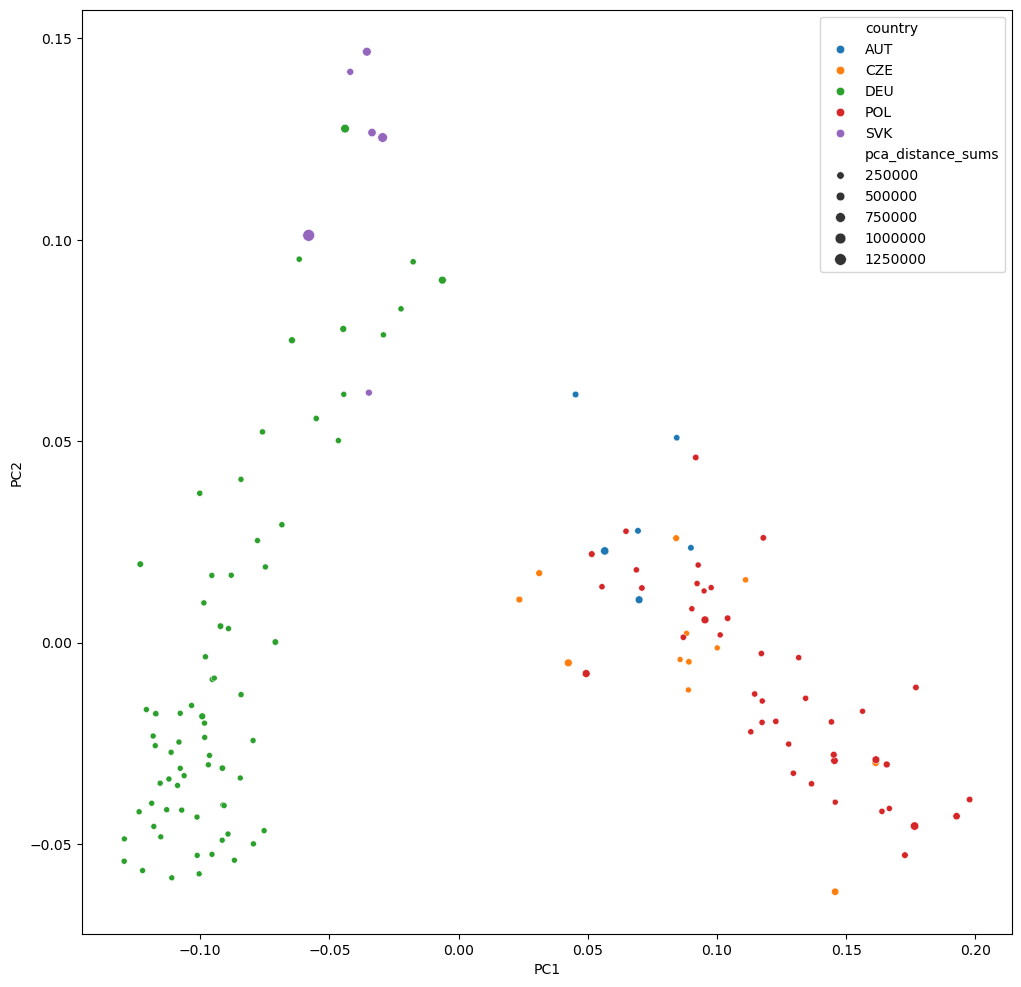

In [51]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x="PC1", y="PC2", hue='country', data=df,  size=df['pca_distance_sums']**2, ax=ax)

Interactive plot.

In [52]:
scatter = jscatter.Scatter(data=df, x='PC1', y='PC2', color_by='country', tooltip=True, tooltip_properties=["city", "NAME"], size_by=df['pca_distance_sums'].astype(int))
scatter.background('#1E1E20')

scatter.show()